# Advanced Lane Detection

Write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. This notebook contains the detailed testing process. The cells that are used for the final output are explicitly listed in the README.md.

### Step - 0: Load Libraries

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Step - 1: Camera Calibration

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

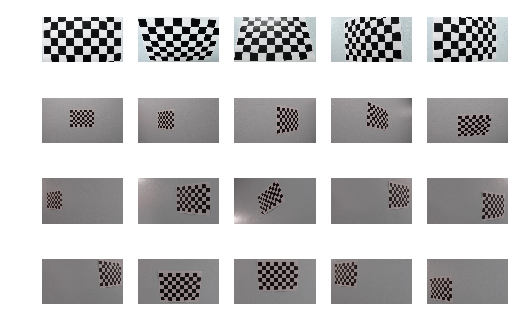

In [2]:
# Read in calibration images
cal_imgs = []

for i in range(1, 21):
    img = cv2.imread('camera_cal/calibration' + str(i) + '.jpg')
    cal_imgs.append(img)
    plt.subplot(4, 5, i)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
# Prepare object points
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for img in cal_imgs:
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points and draw the corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        

# Check the corners were found correctly
for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow(cal_imgs[i-1])
    plt.axis('off')

In [ ]:
# Correcting for Distortion
def cal_undistort(img, objpoints, imgpoints):
    """
    Function takes an image, object points, and image points, performs the camera 
    calibration, image distortion correction and returns the undistorted image
    """
    img_size = (img.shape[1], img.shape[0])
    
    # camera calibration, given object points, image points, 
    # and the shape of the grayscale image:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, 
                                                       None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Make sure cal_undistort works correctly
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_imgs[0])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cal_undistort(cal_imgs[0], objpoints, imgpoints))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Step - 2: Pipeline (test images)

In [ ]:
# Read in test images
test_imgs = []

for i in range(1, 7):
    img = cv2.imread('test_images/test' + str(i) + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_imgs.append(img)
    plt.subplot(1, 6, i)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
# Read in straight line images
straight_lines_imgs = []

for i in range(1, 3):
    img = cv2.imread('test_images/straight_lines' + str(i) + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    straight_lines_imgs.append(img)
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.axis('off')

#### a. Apply a distortion correction to raw images.

In [ ]:
# An example of a distortion-corrected image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_imgs[0])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cal_undistort(test_imgs[0], objpoints, imgpoints))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### b. Use color transforms, gradients, etc., to create a thresholded binary image.

##### b.1 Sobel Operator

Sobel operator - In the above images, you can see that both the gradients taken in the x and y-direction detect the lane lines and pick up various other edges. Taking the gradient in the x-direction emphasizes edges closer to vertical and in the y-direction, edges closer to horizontal.

In [ ]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=5, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##### b. 2 Magnitude of the Gradient

Magnitude of the Gradient - x-gradient does a cleaner job of picking up the lane lines, but you can see the lines in the y-gradient as well.The magnitude, or absolute value of the gradient is just the square root of the squares of the individual x and y gradients; for a gradient in both the x and y directions, the magnitude is the square root of the sum of the squares. 
Taking the gradient over larger regions can smooth over noisy intensity fluctuations on small scales. 
When you play around with the thresholding for the gradient magnitude in the previous exercise, you find what you might expect, namely, that it picks up the lane lines well, but with a lot of other stuff detected too. Gradient magnitude is at the heart of Canny edge detection, and is why Canny works well for picking up all edges, but in the case of lane lines, we're interested only in edges of a particular orientation. So now we will explore the direction, or orientation, of the gradient.

In [ ]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
mag_binary = mag_thresh(image, sobel_kernel=21, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##### b. 3 Direction of the Gradient

Direction of the Gradient The direction of the gradient is simply the arctangent of the y-gradient divided by the x-gradient. Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians, covering a range of −π/2 to π/2. An orientation of 0 implies a horizontal line and orientations of +/−π/2 imply vertical lines.

In [ ]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.2))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##### b. 4 Combining Thresholds

Now consider how you can use various aspects of your gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels. Specifically, think about how you can use thresholds of the x and y gradients, the overall gradient magnitude, and the gradient direction to focus on pixels that are likely to be part of the lane lines.

In [ ]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

# a selection for pixels where both the x and y gradients meet the threshold criteria, 
# or the gradient magnitude and direction are both within their threshold values.
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

##### b. 5 Color Thresholding

From these examples, you can see that the S channel is probably your best bet, given that it's cleaner than the H result and doing a bit better than the R channel or simple grayscaling. S channel is still doing a fairly robust job of picking up the lines under very different color and contrast conditions, while the other selections look messy. You could tweak the thresholds and get closer in the other channels, but the S channel is preferable because it is more robust to changing conditions.
It's worth noting, however, that the R channel still does rather well on the white lines, perhaps even better than the S channel. As with gradients, it's worth considering how you might combine various color thresholds to make the most robust identification of the lines.

In [ ]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(image, thresh=(100, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##### b. 6 Color and Gradient

The final image color_binary is a combination of binary thresholding the S channel (HLS) and binary thresholding the result of applying the Sobel operator in the x direction on the original image.
(Left) Stacked image; the green is the gradient threshold component and the blue is the color channel threshold component. (Right) black and white combined thresholded image - this one has combined both gradient and color thresholds into one image.
try out various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible.

In [ ]:
def color_grad(img, s_thresh, sx_thresh):
    img = np.copy(img)
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,1]

    # Sobel x
        # Take the derivative in x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) 
        # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### c. Apply a perspective transform to rectify binary image ("birds-eye view").

many perspective transform algorithms will programmatically detect four source points in an image based on edge or corner detection and analyzing attributes like color and surrounding pixels.

identify four source points for your perspective transform. In this case, you can assume the road is a flat plane. This isn't strictly true, but it can serve as an approximation for this project. You would like to pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above.

The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

##### c. 1 Straight lines

##### c. 2 Curved lines

Those same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed). When applying the transform to new images, the test of whether or not you got the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved.

You can assume the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines you've detected. The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane.

In [ ]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M


#### d. Detect lane pixels and fit to find the lane boundary.
Locate the Lane Lines and Fit a Polynomial

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

##### d. 1 Line Finding Method: Peaks in a Histogram
With this histogram I am adding up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. I can use that as a starting point for where to search for the lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

##### d. 2 Implement Sliding Windows and Fit a Polynomial
Suppose you've got a warped binary image called binary_warped and you want to find which "hot" pixels are associated with the lane lines. Here's a basic implementation of the method shown in the animation above. You should think about how you could improve this implementation to make sure you can find the lines as robustly as possible!

In [ ]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [ ]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

##### d. 3 Skip the sliding windows step once you know where the lines are
Now you know where the lines are you have a fit! In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous line position like this:

In [ ]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame. This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.

#### e. Determine the curvature of the lane and vehicle position with respect to center.

##### e. 1 Radius of Curvature
The y values of your image increase from top to bottom, so if, for example, you wanted to measure the radius of curvature closest to your vehicle, you could evaluate the formula above at the y value corresponding to the bottom of your image, or in Python, at yvalue = image.shape[0].

In [ ]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space. So we actually need to repeat this calculation after converting our x and y values to real world space.

This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In [ ]:
#So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

#### f. Warp the detected lane boundaries back onto the original image.

Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

#### g. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Step - 2: Pipeline (video)

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip('solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Keeping track of recent measurements
After you've tuned your pipeline on test images, you'll run on a video stream, just like in the first project. In this case, however, you're going to keep track of things like where your last several detections of the lane lines were, what the curvature was etc., so you can properly treat new detections. To do this, it's useful to define a Line() class to keep track of all the interesting parameters you measure from frame to frame. Here's an example:

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

You can create an instance of the Line() class for the left and right lane lines to keep track of recent detections and to perform sanity checks.

**Automatically determining if your detected lines are the real thing**
Ok, so your algorithm found some lines, but before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

**Checking that they have similar curvature**
Checking that they are separated by approximately the right distance horizontally
Checking that they are roughly parallel
After determining you found the lines, where to look in the next frame
Once you've found the lane lines in one frame of video, and you are reasonably confident they are actually the lines you are looking for, you don't need to search blindly in the next frame. You can simply search within a window around the previous detection. For example, if you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center. Double check the bottom of the page here to remind yourself how this works. Then check that your new line detections makes sense, i.e., expected curvature, separation, and parallel.

**If you lose track of the lines**
If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably go back to the blind search method using a histogram and sliding window, or other method, to re-establish your measurement.

**Smoothing your measurement**
Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.